# ECG Compression and HR Evaluation (Fixed Sampling Rate 125 Hz)
Notebook ini memuat:
- Filter sinyal ECG
- Kompresi DWT + quant dan LZMA
- Dekompresi
- Evaluasi PRD & CC
- Perbandingan Heart Rate (HR)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import zlib
import lzma
import lz4.frame
from scipy.signal import butter, filtfilt, find_peaks
from scipy.fftpack import dct, idct


In [3]:
FS = 125  # Sampling rate Hz
df = pd.read_csv('ecg_raw_125hz_ade2 copy 2.csv')
ecg_signal = df['ecg_value'].to_numpy()
t = np.arange(len(ecg_signal)) / FS

In [4]:
def bandpass_filter(signal, fs=125, lowcut=0.5, highcut=40.0, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

filtered_ecg = bandpass_filter(ecg_signal, fs=FS)

In [5]:
def compress_dwt_per_level_zlib(signal, level=3, q_bits=8): 
    coeffs = pywt.wavedec(signal, 'db4', level=level)
    compressed_parts = []
    metadata = []

    for c in coeffs:
        min_val = np.min(c)
        max_val = np.max(c)
        q_step = (max_val - min_val) / (2 ** q_bits) if max_val != min_val else 1.0

        quantized = np.round((c - min_val) / q_step).astype(np.uint8)
        compressed = zlib.compress(quantized.tobytes())

        compressed_parts.append(compressed)
        metadata.append({
            "length": len(c),
            "min_val": float(min_val),
            "q_step": float(q_step)
        })

    return compressed_parts, metadata


def decompress_dwt_per_level_zlib(compressed_parts, metadata, level=3):
    coeffs = []

    for compressed, meta in zip(compressed_parts, metadata):
        quantized = np.frombuffer(zlib.decompress(compressed), dtype=np.uint8)
        assert len(quantized) == meta['length'], "Panjang data tidak sesuai!"

        dequantized = quantized.astype(np.float32) * meta['q_step'] + meta['min_val']
        coeffs.append(dequantized)

    reconstructed = pywt.waverec(coeffs, 'db4')
    return reconstructed

In [6]:
def compress_lzma_8bit(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    q_step = (max_val - min_val) / 256  # 8-bit = 2^8 = 256 level
    if q_step == 0:
        q_step = 1.0  # Hindari pembagian nol kalau sinyal flat

    quantized = np.round((signal - min_val) / q_step).astype(np.uint8)
    compressed = lzma.compress(quantized.tobytes())

    return compressed, min_val, q_step, len(signal)

def decompress_lzma_8bit(compressed_data, length, min_val, q_step):
    quantized = np.frombuffer(lzma.decompress(compressed_data), dtype=np.uint8)
    
    print(f"[DEBUG] Expected Length: {length}, Decompressed Length: {len(quantized)}")

    if len(quantized) != length:
        raise ValueError(f"Panjang data mismatch: expected {length}, got {len(quantized)}")

    reconstructed = quantized.astype(np.float32) * q_step + min_val
    return reconstructed

In [7]:
def compress_dct_quant_zlib(signal, q_bits=8):
    dct_coeff = dct(signal, norm='ortho')

    # Quantisasi
    min_val = np.min(dct_coeff)
    max_val = np.max(dct_coeff)
    q_step = (max_val - min_val) / (2 ** q_bits) if max_val != min_val else 1.0
    quantized = np.round((dct_coeff - min_val) / q_step).astype(np.uint8)

    # Kompresi ZLIB
    compressed = zlib.compress(quantized.tobytes())

    # Simpan metadata
    metadata = {
        'length': len(signal),
        'min_val': float(min_val),
        'q_step': float(q_step)
    }

    return compressed, metadata

def decompress_dct_quant_zlib(compressed, metadata):
    """
    Dekompresi sinyal dari DCT + Quant + ZLIB
    """
    quantized = np.frombuffer(zlib.decompress(compressed), dtype=np.uint8)
    assert len(quantized) == metadata['length'], "Panjang tidak sesuai"

    # Dequantisasi
    dequantized = quantized.astype(np.float32) * metadata['q_step'] + metadata['min_val']

    # Rekonstruksi sinyal dengan IDCT
    reconstructed = idct(dequantized, norm='ortho')
    return reconstructed

In [8]:
def compress_quant_lz4(signal, q_bits=8):
    min_val = np.min(signal)
    max_val = np.max(signal)
    q_step = (max_val - min_val) / (2 ** q_bits) if max_val != min_val else 1.0

    quantized = np.round((signal - min_val) / q_step).astype(np.uint8)
    compressed = lz4.frame.compress(quantized.tobytes())

    metadata = {
        'length': len(signal),
        'min_val': float(min_val),
        'q_step': float(q_step)
    }

    return compressed, metadata


def decompress_quant_lz4(compressed, metadata):
    quantized = np.frombuffer(lz4.frame.decompress(compressed), dtype=np.uint8)
    assert len(quantized) == metadata['length'], "Panjang tidak sesuai"

    signal = quantized.astype(np.float32) * metadata['q_step'] + metadata['min_val']
    return signal


In [9]:
def compute_hr(signal, fs=125, window_sec=6, step_sec=2):
    window_size = window_sec * fs
    step_size = step_sec * fs
    hr_values = []
    times = []
    for start in range(0, len(signal) - window_size + 1, step_size):
        segment = signal[start:start + window_size]
        peaks, _ = find_peaks(segment, distance=fs * 0.6)
        hr = 60.0 / np.mean(np.diff(peaks) / fs) if len(peaks) > 1 else 0
        hr_values.append(hr)
        times.append(start / fs)
    return np.array(times), np.array(hr_values)

def calculate_metrics(original, reconstructed):
    prd = 100 * np.sqrt(np.sum((original - reconstructed) ** 2) / np.sum(original ** 2))
    cc = np.corrcoef(original, reconstructed)[0, 1]
    return prd, cc

In [10]:
compressed_parts, metadata = compress_dwt_per_level_zlib(filtered_ecg, level=3, q_bits=6)
recon_36 = decompress_dwt_per_level_zlib(compressed_parts, metadata, level=3)[:len(filtered_ecg)]

compressed_lzma, min_val_lzma, q_step_lzma, orig_len = compress_lzma_8bit(filtered_ecg)
recon_lzma = decompress_lzma_8bit(compressed_lzma, orig_len, min_val_lzma, q_step_lzma)

compressed_dctzlib, metadata_dctzlib = compress_dct_quant_zlib(filtered_ecg, q_bits=8)
recon_dctzlib = decompress_dct_quant_zlib(compressed_dctzlib, metadata_dctzlib)

compressed_lz4, metadata_lz4 = compress_quant_lz4(filtered_ecg, q_bits=8)
recon_lz4 = decompress_quant_lz4(compressed_lz4, metadata_lz4)

[DEBUG] Expected Length: 1250, Decompressed Length: 1250


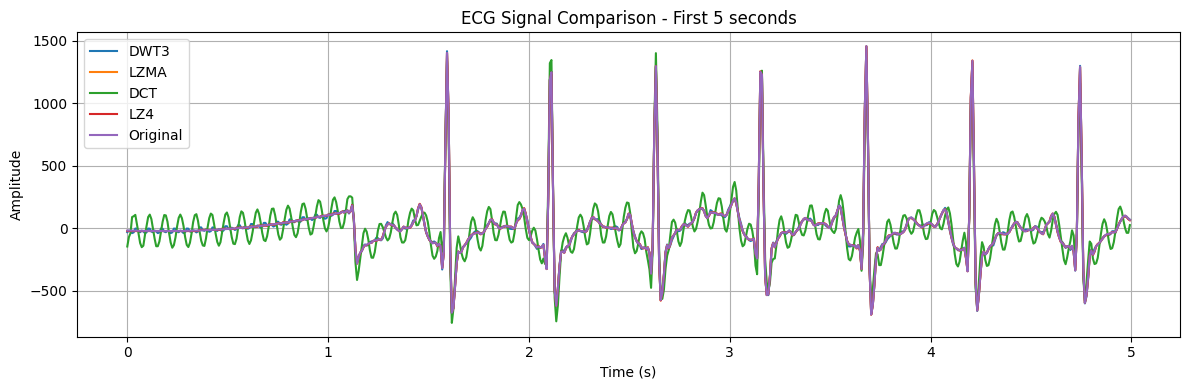

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(t[:625], recon_36[:625], label='DWT3')
plt.plot(t[:625], recon_lzma[:625], label='LZMA')
plt.plot(t[:625], recon_dctzlib[:625], label='DCT')
plt.plot(t[:625], recon_lz4[:625], label='LZ4')
plt.plot(t[:625], filtered_ecg[:625], label='Original')
plt.title('ECG Signal Comparison - First 5 seconds')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

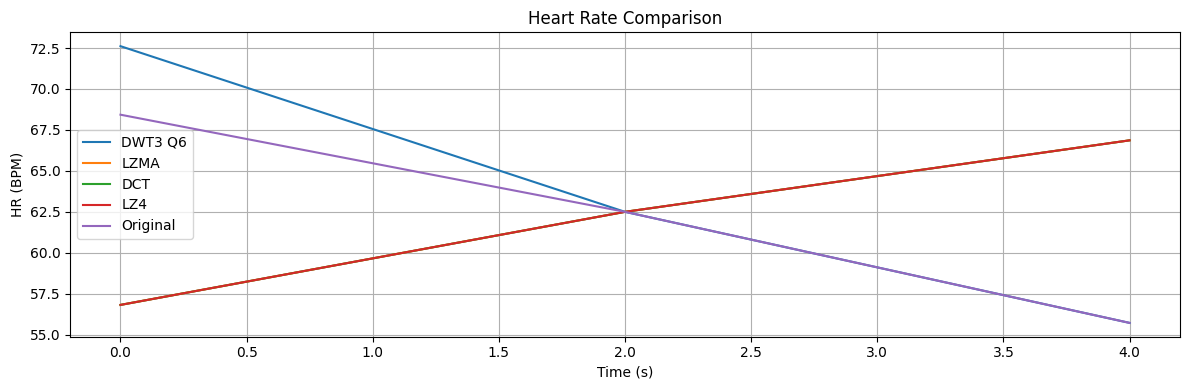

In [12]:
t_hr, hr_orig = compute_hr(filtered_ecg)
_, hr_36 = compute_hr(recon_36)
_, hr_lzma = compute_hr(recon_lzma)
_, hr_dct = compute_hr(recon_lzma)
_, hr_lz4 = compute_hr(recon_lz4)

plt.figure(figsize=(12, 4))
plt.plot(t_hr, hr_36, label='DWT3 Q6')
plt.plot(t_hr, hr_lzma, label='LZMA')
plt.plot(t_hr, hr_dct, label='DCT')
plt.plot(t_hr, hr_lz4, label='LZ4')
plt.plot(t_hr, hr_orig, label='Original')
plt.title('Heart Rate Comparison')
plt.xlabel('Time (s)'); plt.ylabel('HR (BPM)')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

In [13]:
# Ukuran data mentah asumsi int16 per sampel
original_size = len(filtered_ecg) * 2  

# Total ukuran hasil kompresi per metode
size_dwt_q6 = sum(len(part) for part in compressed_parts)  # DWT per-level
size_lzma_q8 = len(compressed_lzma)  # LZMA + Quantization 8-bit

# Tambahkan hasil DCT + Quant + ZLIB
size_dct_q8 = len(compressed_dctzlib)
prd_dct, cc_dct = calculate_metrics(filtered_ecg, recon_dctzlib)

# Hitung metrik performa
prd_dwt, cc_dwt = calculate_metrics(filtered_ecg, recon_36)
prd_lzma, cc_lzma = calculate_metrics(filtered_ecg, recon_lzma)

prd_lz4, cc_lz4 = calculate_metrics(filtered_ecg, recon_lz4)
size_lz4 = len(compressed_lz4)

# Ringkasan hasil
results = {
    'DWT3 + Q6': (size_dwt_q6, prd_dwt, cc_dwt),
    'LZMA + Q8': (size_lzma_q8, prd_lzma, cc_lzma),
    'DCT + Q8 + ZLIB': (size_dct_q8, prd_dct, cc_dct),
    'Quant + LZ4' : (size_lz4, prd_lz4, cc_lz4),
}

# Cetak rapi
for name, (size, prd, cc) in results.items():
    print(f'{name}:')
    print(f'  Compressed Size   : {size} bytes')
    print(f'  Original Size     : {original_size} bytes')
    print(f'  Compression %     : {size / original_size * 100:.2f}% of original')
    print(f'  Compression Ratio : {original_size / size:.2f}x')
    print(f'  PRD               : {prd:.2f}%')
    print(f'  CC (Correlation)  : {cc:.4f}\n')


DWT3 + Q6:
  Compressed Size   : 661 bytes
  Original Size     : 2500 bytes
  Compression %     : 26.44% of original
  Compression Ratio : 3.78x
  PRD               : 3.62%
  CC (Correlation)  : 0.9993

LZMA + Q8:
  Compressed Size   : 928 bytes
  Original Size     : 2500 bytes
  Compression %     : 37.12% of original
  Compression Ratio : 2.69x
  PRD               : 25.10%
  CC (Correlation)  : 0.9682

DCT + Q8 + ZLIB:
  Compressed Size   : 778 bytes
  Original Size     : 2500 bytes
  Compression %     : 31.12% of original
  Compression Ratio : 3.21x
  PRD               : 37.38%
  CC (Correlation)  : 0.9305

Quant + LZ4:
  Compressed Size   : 1176 bytes
  Original Size     : 2500 bytes
  Compression %     : 47.04% of original
  Compression Ratio : 2.13x
  PRD               : 25.10%
  CC (Correlation)  : 0.9682

